In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## 1. Datensammlung und Datenbereinigung

Nicht-Länder aussortieren und Länder ohne Daten rausfiltern.

In [2]:
non_country_keywords = [
    "Africa", "Europe", "America", "Asia", "Oceania", "Arab", "World",
    "High income", "Low income", "Middle income", "Euro area", "OECD", "IDA",
    "IBRD", "G7", "G20", "Least developed", "Landlocked", "Small states", "Sub-Saharan",
    "Heavily indebted", "demographic dividend", "middle income", "Other"
]

allowlist = {
    "Egypt, Arab Rep.", "Saudi Arabia", "South Africa",
    "Syrian Arab Republic", "United Arab Emirates", "Central African Republic"
}
def is_region_or_group(name):
    return (
        any(keyword in str(name) for keyword in non_country_keywords)
        and name not in allowlist
    )
def clean_df(df):
    df = df[~df["Country Name"].apply(is_region_or_group)]
    mask = (df.iloc[:, 3:].fillna(0) != 0).any(axis=1)
    df = df[mask].reset_index(drop=True)
    return df

In [3]:
df_export = pd.read_csv("./data/exports.csv", sep=',', skiprows=4)
df_export = df_export.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_export = clean_df(df_export)

df_military = pd.read_csv("./data/military_expenditure.csv", sep=',', skiprows=4)
df_military = df_military.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_military = clean_df(df_military)

df_gdp = pd.read_csv("./data/gdp.csv", sep=',', skiprows=4)
df_gdp = df_gdp.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_gdp = clean_df(df_gdp)

df_import = pd.read_csv("./data/imports.csv", sep=',', skiprows=4)
df_import = df_import.drop(columns=["Indicator Name", "Indicator Code", "2024", "Unnamed: 69"])
df_import = clean_df(df_import)

## 2. Identifizieren von Ausreißern

Ausreißer in den 4 DataFrames (Exports, Imports, GDP, Military)

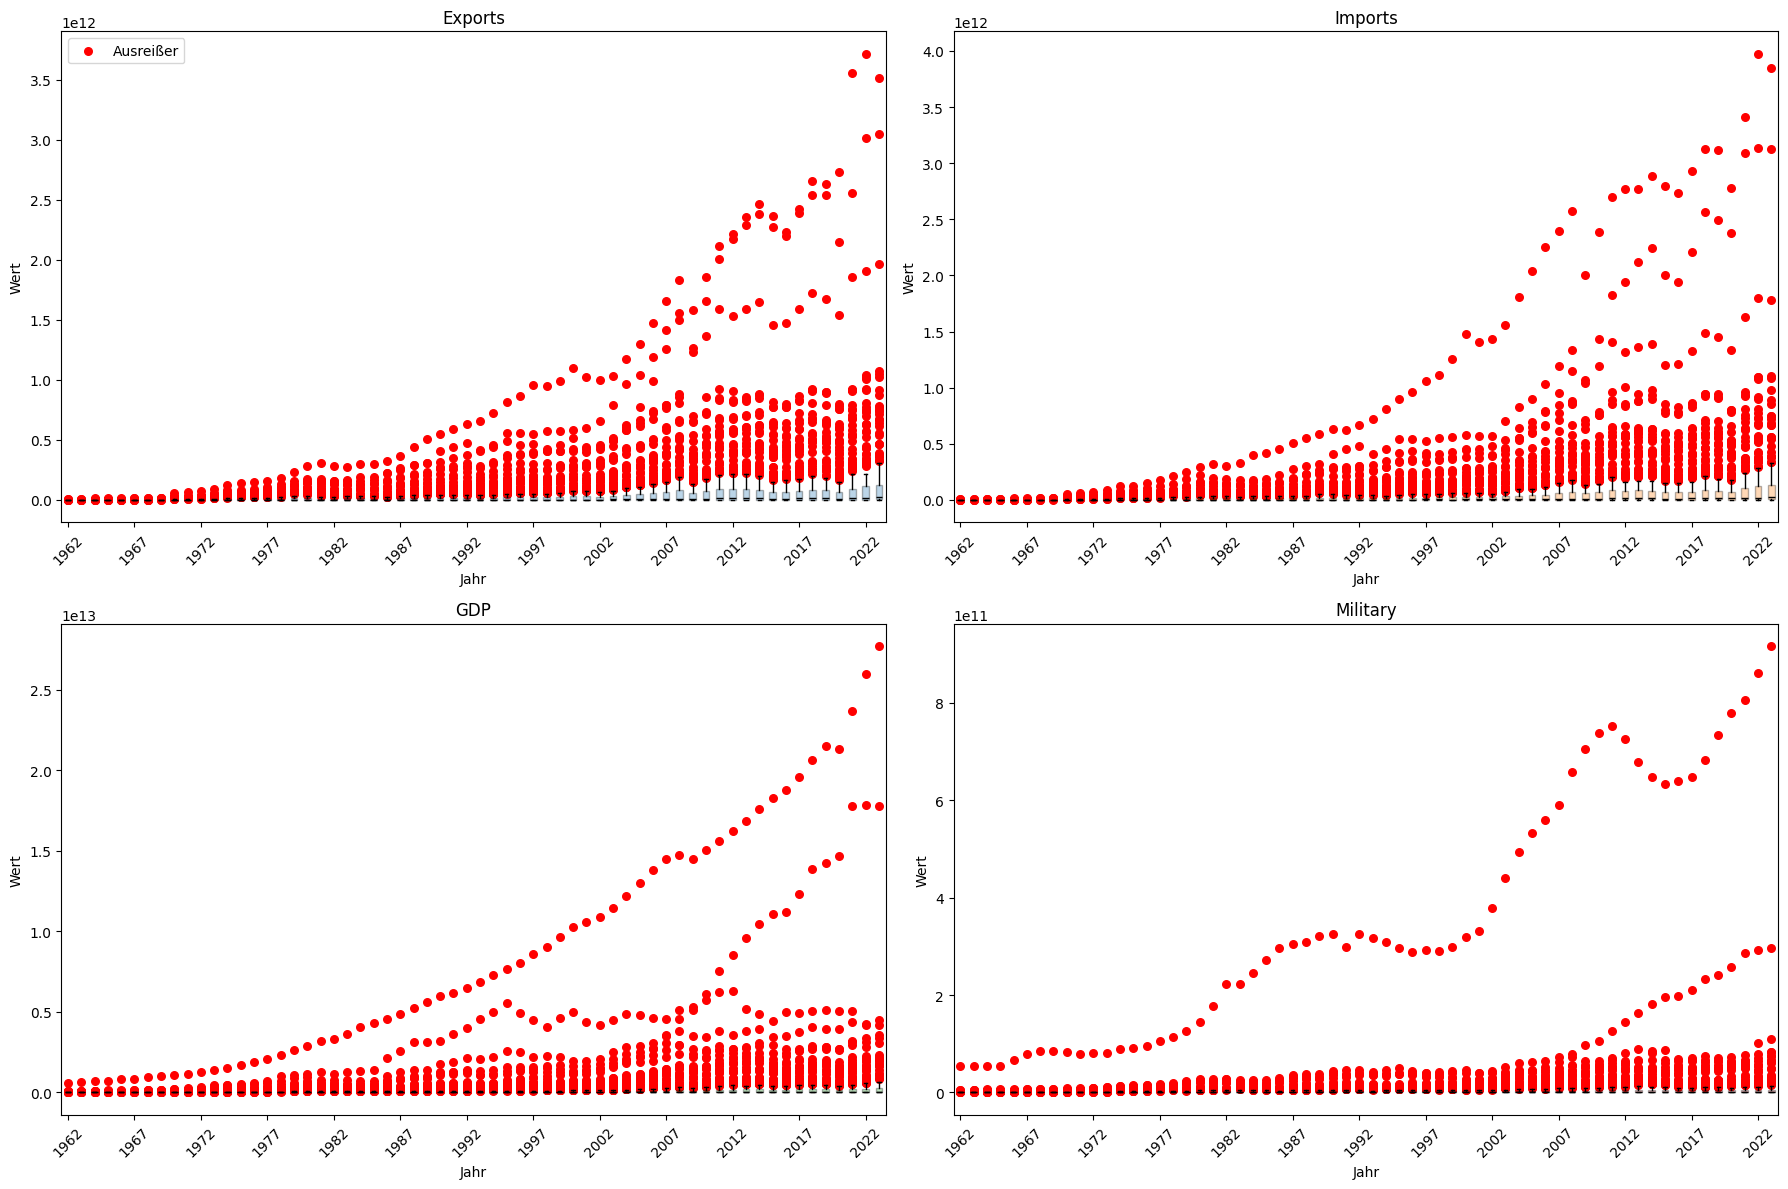

In [12]:
def find_outliers_iqr(df):
	outliers = {}
	years = df.columns[4:]
	for year in years:
		vals = df[year]
		q1 = vals.quantile(0.25)
		q3 = vals.quantile(0.75)
		iqr = q3 - q1
		lower = q1 - 1.5 * iqr
		upper = q3 + 1.5 * iqr
		outlier_idx = vals.index[(vals < lower) | (vals > upper)].tolist()
		outliers[year] = outlier_idx
	return outliers

outliers_exports_iqr = find_outliers_iqr(df_export)
outliers_imports_iqr = find_outliers_iqr(df_import)
outliers_gdp_iqr = find_outliers_iqr(df_gdp)
outliers_military_iqr = find_outliers_iqr(df_military)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
dfs = {
	'Exports': (df_export, outliers_exports_iqr),
	'Imports': (df_import, outliers_imports_iqr),
	'GDP': (df_gdp, outliers_gdp_iqr),
	'Military': (df_military, outliers_military_iqr)
}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for ax, (title, (df, outliers)), color in zip(axes.flat, dfs.items(), colors):
	years = df.columns[4:]
	data = [df[year].dropna() for year in years]
	bp = ax.boxplot(data, patch_artist=True, showfliers=False,
					boxprops=dict(facecolor=color, alpha=0.3),
					medianprops=dict(color='black'))
	for idx, year in enumerate(years):
		out_idx = outliers.get(year, [])
		if out_idx:
			out_vals = df.loc[out_idx, year]
			ax.scatter([idx+1]*len(out_vals), out_vals, color='red', s=30, label='Ausreißer' if idx == 0 else "")
	ax.set_title(title)
	ax.set_xlabel('Jahr')
	ax.set_ylabel('Wert')
	xtick_idx = range(0, len(years), 5)
	ax.set_xticks([i+1 for i in xtick_idx])
	ax.set_xticklabels([years[i] for i in xtick_idx], rotation=45)
	if title == 'Exports':
		ax.legend()

plt.tight_layout()
plt.show()

Ausreißer von fd_complete

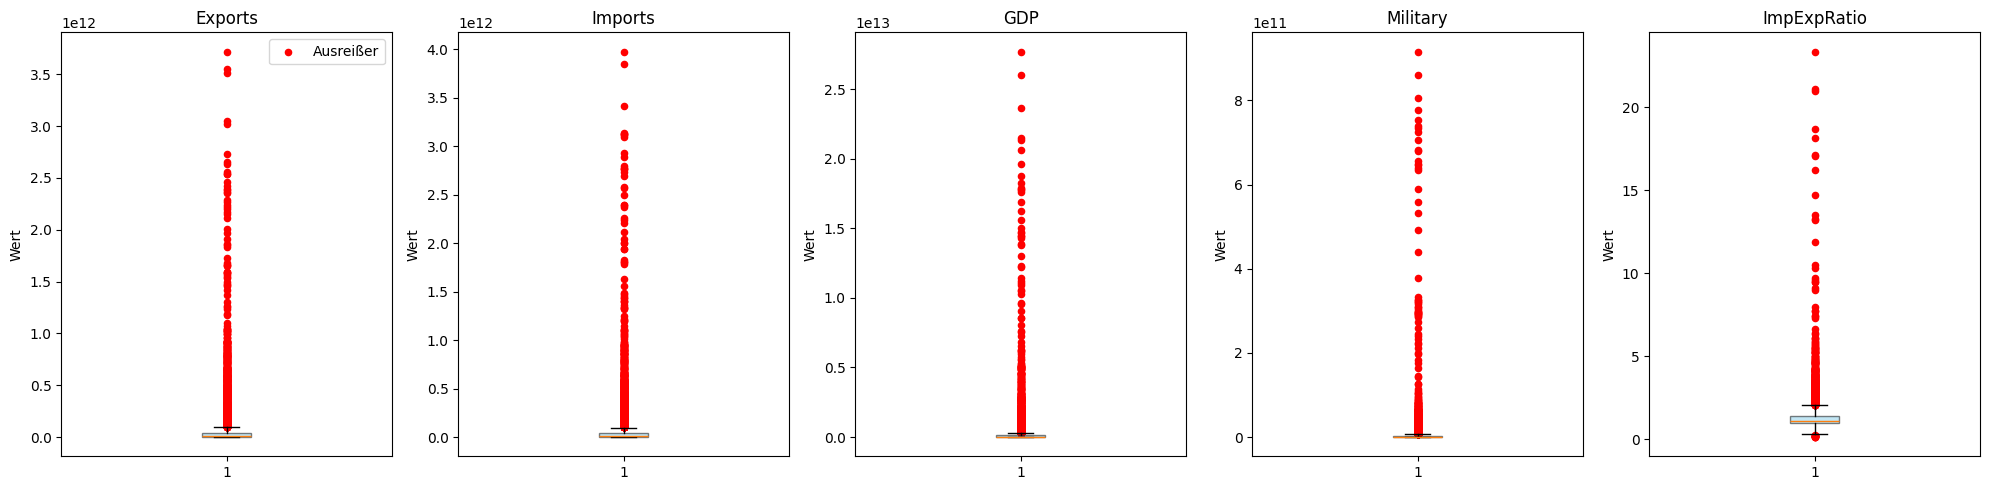

In [13]:
def find_outliers_iqr_long(df, columns):
	outliers = {}
	for col in columns:
		vals = df[col].dropna()
		q1 = vals.quantile(0.25)
		q3 = vals.quantile(0.75)
		iqr = q3 - q1
		lower = q1 - 1.5 * iqr
		upper = q3 + 1.5 * iqr
		outlier_idx = vals.index[(vals < lower) | (vals > upper)].tolist()
		outliers[col] = outlier_idx
	return outliers

cols = ["Exports", "Imports", "GDP", "Military", "ImpExpRatio"]
outliers_complete = find_outliers_iqr_long(df_complete, cols)
fig, axes = plt.subplots(1, len(cols), figsize=(20, 5))
for ax, col in zip(axes, cols):
	vals = df_complete[col]
	bp = ax.boxplot(vals.dropna(), patch_artist=True, showfliers=False, boxprops=dict(facecolor='skyblue', alpha=0.5))
	out_idx = outliers_complete[col]
	if out_idx:
		out_vals = df_complete.loc[out_idx, col]
		ax.scatter(np.ones(len(out_vals)), out_vals, color='red', s=20, label='Ausreißer')
	ax.set_title(col)
	ax.set_ylabel('Wert')
	if col == "Exports":
		ax.legend()
plt.tight_layout()
plt.show()

## 3. Überprüfen der Normalverteilung

DataFrames in ein gemeinsames Format bringen

In [4]:
from scipy.stats import shapiro

df_export_long = df_export.melt(
	id_vars=["Country Name", "Country Code"],
	var_name="Year",
	value_name="Exports"
)
df_import_long = df_import.melt(
	id_vars=["Country Name", "Country Code"],
	var_name="Year",
	value_name="Imports"
)
df_gdp_long = df_gdp.melt(
	id_vars=["Country Name", "Country Code"],
	var_name="Year",
	value_name="GDP"
)
df_military_long = df_military.melt(
	id_vars=["Country Name", "Country Code"],
	var_name="Year",
	value_name="Military"
)

Zusammenführen aller Informationen: Am Ende hat man einen einzigen Datensatz, in dem jede Zeile für ein bestimmtes Land in einem bestimmten Jahr alle vier Werte beieinanderstehen.

In [5]:
df_merged = df_export_long.merge(
	df_import_long, on=["Country Name", "Country Code", "Year"], how="outer"
).merge(
	df_gdp_long, on=["Country Name", "Country Code", "Year"], how="outer"
).merge(
	df_military_long, on=["Country Name", "Country Code", "Year"], how="outer"
)

Import-zu-Export-Verhältnis berechnen

In [6]:
df_merged["ImpExpRatio"] = df_merged["Imports"] / df_merged["Exports"]

Unvollständige Einträge aussortieren

In [7]:
df_complete = df_merged.dropna(subset=["Military", "ImpExpRatio", "GDP"])

Normalverteilungs-Test für jede Kennzahl


In [8]:
shapiro_results = {}
for col in ["Military", "ImpExpRatio", "GDP"]:
	vals = df_complete[col].values
	sample = vals if len(vals) < 5000 else np.random.choice(vals, 5000, replace=False)
	stat, p = shapiro(sample)
	shapiro_results[col] = p

Ergebnis auswerten

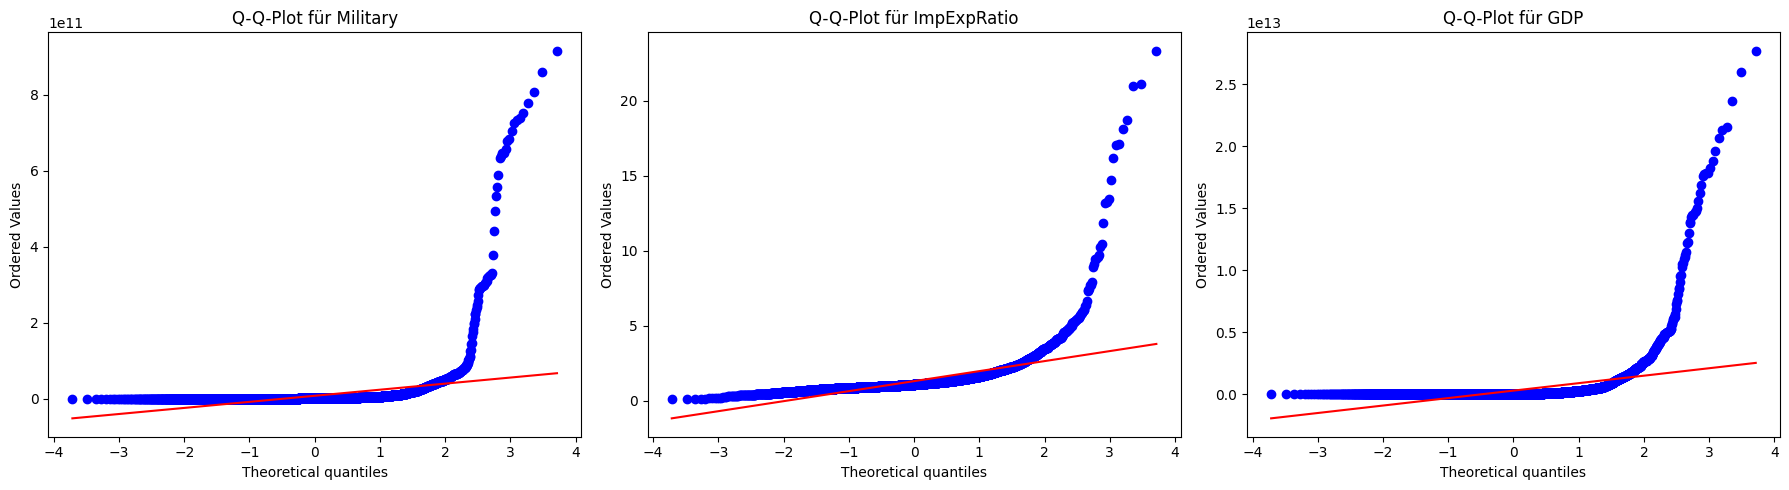

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cols = ["Military", "ImpExpRatio", "GDP"]

for ax, col in zip(axes, cols):
	vals = df_complete[col].dropna()
	stats.probplot(vals, dist="norm", plot=ax)
	ax.set_title(f"Q-Q-Plot für {col}")

plt.tight_layout()
plt.show()


In [9]:
for col, p in shapiro_results.items():
	if p >= 0.05:
		print(f"{col}: normalverteilt (p={p:.2e})")
	else:
		print(f"{col}: nicht normalverteilt (p={p:.2e})")

Military: nicht normalverteilt (p=1.31e-92)
ImpExpRatio: nicht normalverteilt (p=2.19e-83)
GDP: nicht normalverteilt (p=4.55e-90)


In jedem Fall weicht die Verteilung (blaue Punkte) stark von der Normalverteilung (rote Linie) ab. Die p-values befinden sich auch außerhalb der für Normalverteilungen in Frage kommenden Zonen. Daher ist die Annahme der Normalverteilung nicht gegeben.

In [17]:
print("\nEmpfehlung:")
if all(p >= 0.05 for p in shapiro_results.values()):
	print("Alle Variablen sind normalverteilt. Pearson-Korrelation ist geeignet.")
elif all(p < 0.05 for p in shapiro_results.values()):
	print("Alle Variablen sind nicht normalverteilt. Spearman-Korrelation ist geeigneter.")
else:
	print("Einige Variablen sind normalverteilt, andere nicht. Spearman ist robuster und daher zu bevorzugen.")


Empfehlung:
Alle Variablen sind nicht normalverteilt. Spearman-Korrelation ist geeigneter.
